In [39]:
import etl_eda
import importlib
importlib.reload(etl_eda)
from etl_eda import *
import re
import opendatasets as od
from itertools import product
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

Data Extraction

In [40]:
dql = DataQualityLayer()
# Extract and process files
data_frames = dql.extract_data('./competitive-data-science-predict-future-sales')

In [41]:
# Check for duplicates and NA values
dql.duplicates_na_check(data_frames)

DataFrame[2] has duplicates:
                date  date_block_num  shop_id  item_id  item_price  \
76962    05.01.2013               0       54    20130       149.0   
1435367  23.02.2014              13       50     3423       999.0   
1496766  23.03.2014              14       21     3423       999.0   
1671873  01.05.2014              16       50     3423       999.0   
1866340  12.07.2014              18       25     3423       999.0   
2198566  31.12.2014              23       42    21619       499.0   

         item_cnt_day  
76962             1.0  
1435367           1.0  
1496766           1.0  
1671873           1.0  
1866340           1.0  
2198566           1.0  
Percentage of duplicates: 0.00%
Duplicates successfully dropped


Validity: Outliers detection

In [42]:
data_frames[2].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Outliers in item_price

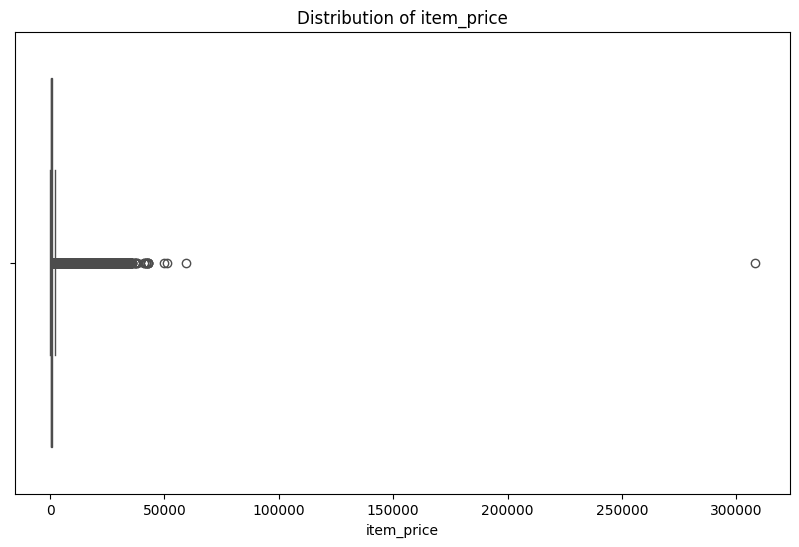

In [43]:
dql.boxplot(data_frames[2], 'item_price')

In [44]:
data_frames[2].loc[data_frames[2].item_price > 50000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
885138,17.09.2013,8,12,11365,59200.0,1.0
1163158,13.12.2013,11,12,6066,307980.0,1.0
1488135,20.03.2014,14,25,13199,50999.0,1.0


In [45]:
data_frames[2].loc[data_frames[2].item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


To get stable results - we will define item price range(0-50000)

In [46]:
data_frames[2] = data_frames[2].loc[(data_frames[2].item_price > 0) & (data_frames[2].item_price < 50000)]

Outliers in item_cnt_day

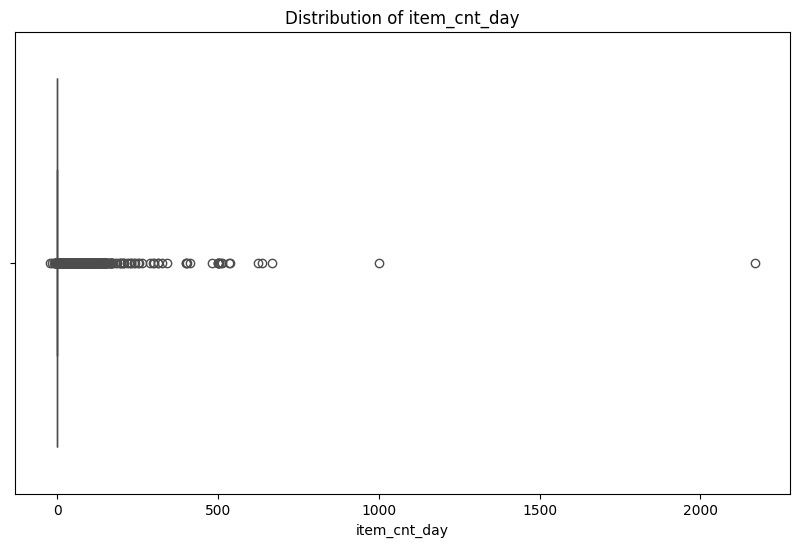

In [47]:
dql.boxplot(data_frames[2], 'item_cnt_day')

In [48]:
data_frames[2].loc[data_frames[2].item_cnt_day >= 1000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


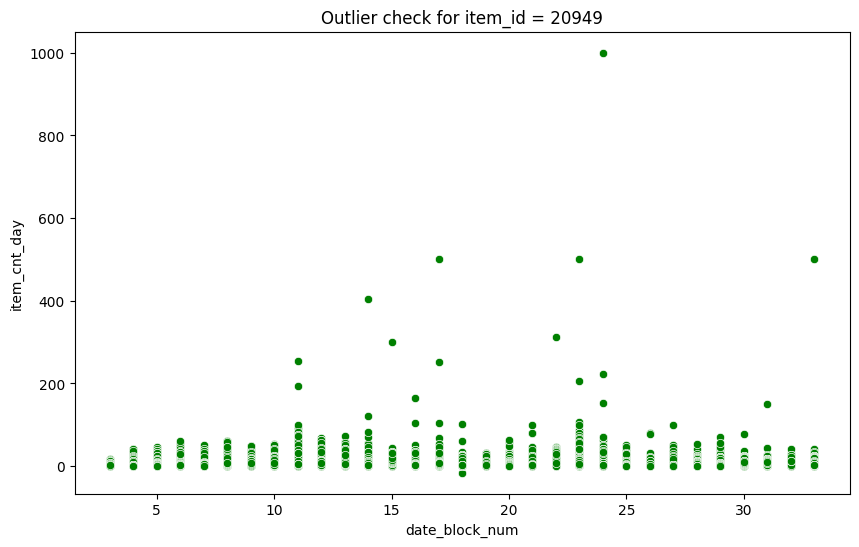

In [49]:
dql.outlier_check(data_frames[2], 'item_id', 20949, 'date_block_num', 'item_cnt_day')

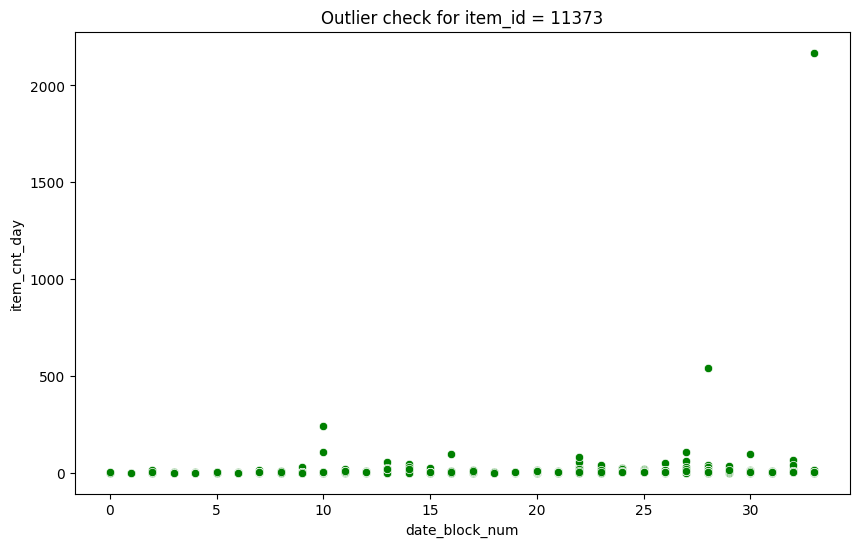

In [50]:
dql.outlier_check(data_frames[2], 'item_id', 11373, 'date_block_num', 'item_cnt_day')

To get stable results - we will drop items with item_cnt_month under 1000

In [51]:
data_frames[2] = data_frames[2].loc[data_frames[2].item_cnt_day < 1000]

In [52]:
data_frames[2].loc[data_frames[2].item_cnt_day < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


We replace negative item_cnt_day values with 0

In [53]:
data_frames[2].loc[data_frames[2].item_cnt_day < 0, 'item_cnt_day'] = 0

Consistency: shop_name correction

In [54]:
pattern1 = "^!"
pattern2 = ""
for name in data_frames[4]['shop_name'].unique():
    data_frames[4].replace({'shop_name': {name: re.sub(pattern1, pattern2, name)}}, inplace = True)

In [55]:
data_frames[4]['shop_name'].unique()

array(['Якутск Орджоникидзе, 56 фран', 'Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²',
       'Интернет-магазин ЧС', 'Казань ТЦ "Бехетле"',
       'Казань ТЦ "ПаркХаус" II', 'Калуга ТРЦ "XXI век"',
       'Коломна ТЦ "Рио"', 'Красноярск ТЦ "Взлетка Плаза"',
       'Красноярск ТЦ "Июнь"', 'Курск ТЦ "Пушкинский"',
       'Москва "Распродажа"', 'Москва МТРЦ "Афи Молл"',
       'Москва Магазин С21', 'Москва ТК "Буденовский" (пав.А2)',
       'Москва ТК "Буденовский" (пав.К7)', 'Москва ТРК "Атриум"',
       'Москва ТЦ "Ареал" (Беляево)', 'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"',
       'Москва ТЦ 

In [56]:
items = data_frames[0]
categories = data_frames[1]
train = data_frames[2]
shops = data_frames[4]
test = data_frames[5]

Itegrity data by int_snt_month

In [57]:
df_sales_per_month = train.groupby(["date_block_num", "shop_id", "item_id"]).agg({'item_cnt_day':'sum', 'item_price': 'mean'})
df_sales_per_month = df_sales_per_month.rename({"item_cnt_day":"item_cnt_month"}, axis=1)
df_sales_per_month.reset_index(inplace = True)

In [58]:
df_sales_per_month.describe().map(lambda x: f"{x:0.1f}")

,date_block_num,shop_id,item_id,item_cnt_month,item_price
count,1609121.0,1609121.0,1609121.0,1609121.0,1609121.0
mean,14.7,32.8,10681.0,2.3,790.7
std,9.5,16.5,6238.9,8.4,1532.1
min,0.0,0.0,0.0,0.0,0.1
25%,6.0,21.0,5045.0,1.0,199.0
50%,14.0,31.0,10497.0,1.0,399.0
75%,23.0,47.0,16060.0,2.0,898.5
max,33.0,59.0,22169.0,1644.0,49782.0


Uniqueness: Check similar named shops

In [59]:
for id in df_sales_per_month['shop_id'].unique():
    if df_sales_per_month[df_sales_per_month['shop_id'] == id].reset_index(drop = True)['date_block_num'].nunique() != 34:
        print(shops.loc[shops.shop_id == id, 'shop_name'].min())

Якутск Орджоникидзе, 56 фран
Якутск ТЦ "Центральный" фран
Воронеж ТРЦ Сити-Парк "Град"
Жуковский ул. Чкалова 39м?
Казань ТЦ "Бехетле"
Москва ТК "Буденовский" (пав.А2)
Москва ТЦ "МЕГА Белая Дача II"
Москва ТЦ "Новый век" (Новокосино)
Москва ТЦ "Перловский"
Москва ТЦ "Серебряный Дом"
СПб ТК "Сенная"
Тюмень ТЦ "Зеленый Берег"
Химки ТЦ "Мега"
Вологда ТРЦ "Мармелад"
Якутск Орджоникидзе, 56
Якутск ТЦ "Центральный"
Цифровой склад 1С-Онлайн
Красноярск ТЦ "Взлетка Плаза"
Выездная Торговля
Тюмень ТРЦ "Кристалл"
РостовНаДону ТРК "Мегацентр Горизонт"
РостовНаДону ТРК "Мегацентр Горизонт" Островной
Томск ТРЦ "Изумрудный Город"
Н.Новгород ТРЦ "РИО"
Мытищи ТРК "XL-3"
Москва "Распродажа"
Жуковский ул. Чкалова 39м²
Новосибирск ТРЦ "Галерея Новосибирск"


pair 1.Якутск Орджоникидзе, 56 фран and Якутск Орджоникидзе, 56

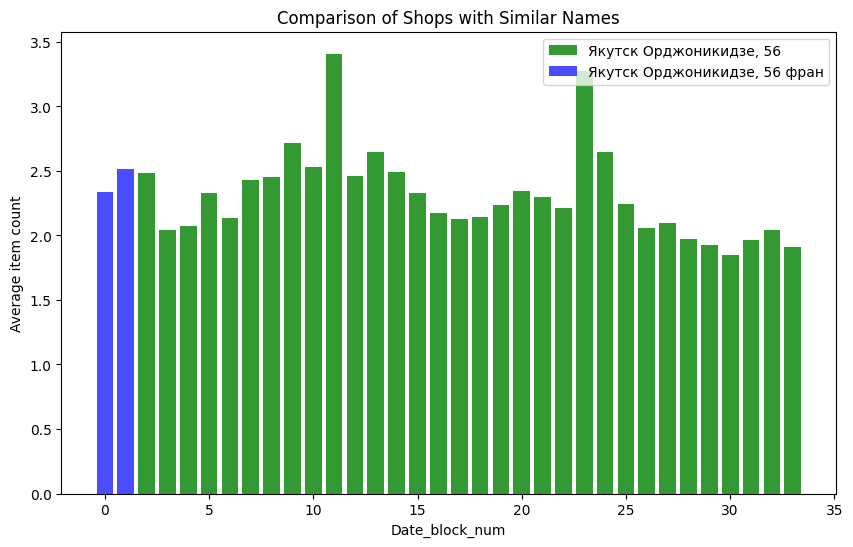

In [60]:
dql.shop_name_comparison(shops, df_sales_per_month, 'Якутск Орджоникидзе, 56', 'Якутск Орджоникидзе, 56 фран')

Combining them - we'll get full range of data

Correcting shops_id in shops dataframe

In [61]:
dql.replace_shops(shops, train, test, 'Якутск Орджоникидзе, 56', 'Якутск Орджоникидзе, 56 фран')

Якутск ТЦ "Центральный" фран, Якутск ТЦ "Центральный"

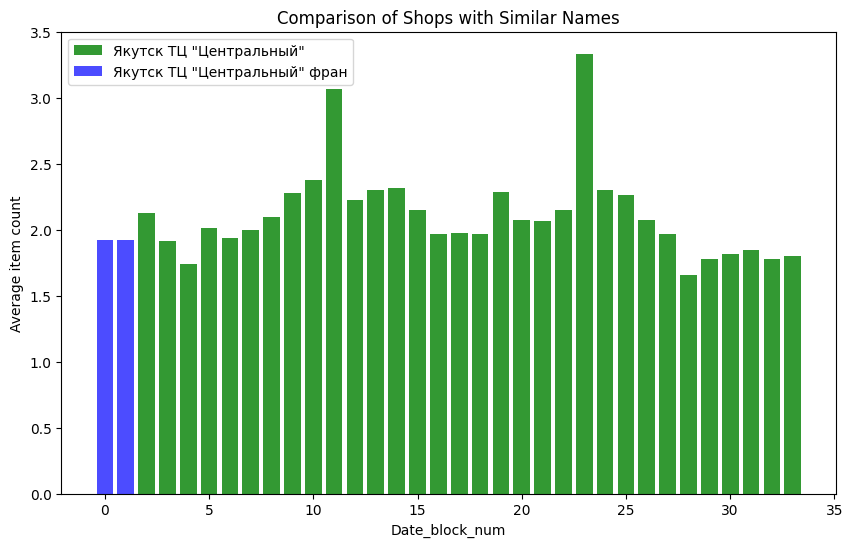

In [62]:
dql.shop_name_comparison(shops, df_sales_per_month, 'Якутск ТЦ "Центральный"', 'Якутск ТЦ "Центральный" фран')

In [63]:
dql.replace_shops(shops, train, test, 'Якутск ТЦ "Центральный"', 'Якутск ТЦ "Центральный" фран')

Жуковский ул. Чкалова 39м?, Жуковский ул. Чкалова 39м²

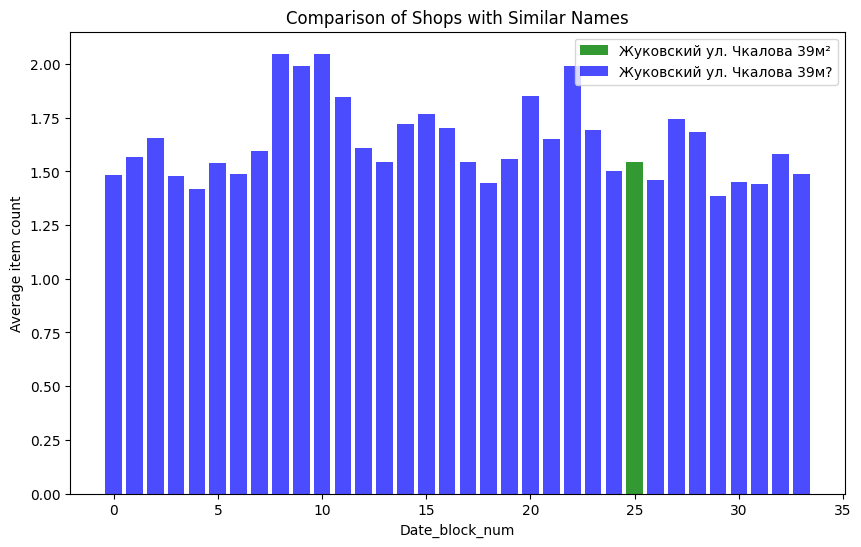

In [64]:
dql.shop_name_comparison(shops, df_sales_per_month,'Жуковский ул. Чкалова 39м²', 'Жуковский ул. Чкалова 39м?')

In [65]:
dql.replace_shops(shops, train, test, 'Жуковский ул. Чкалова 39м²', 'Жуковский ул. Чкалова 39м?')

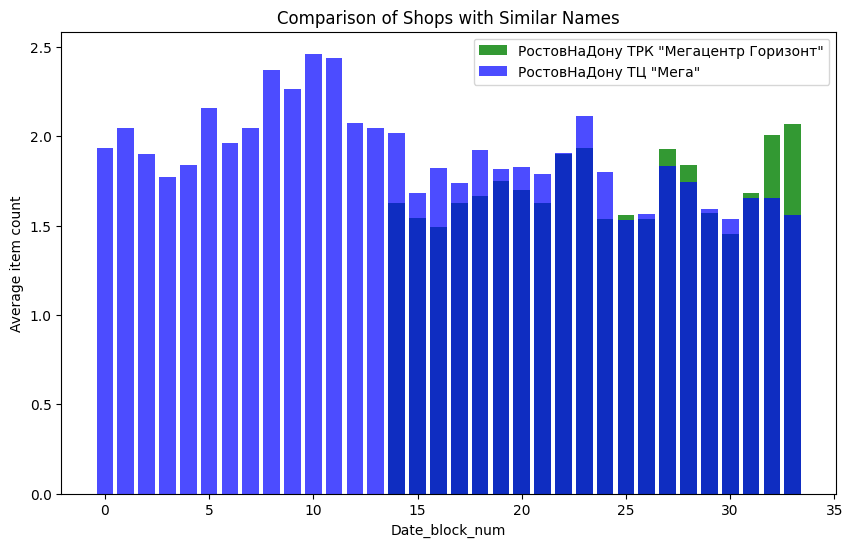

In [66]:
shop_name_1 = 'РостовНаДону ТРК "Мегацентр Горизонт"'
shop_name_2 = 'РостовНаДону ТЦ "Мега"'
dql.shop_name_comparison(shops, df_sales_per_month, shop_name_1, shop_name_2)


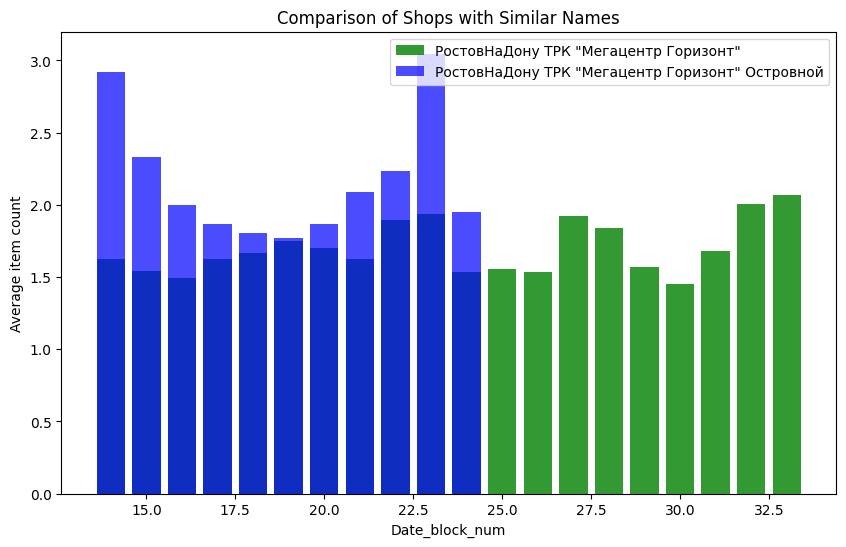

In [67]:
shop_name_1 = 'РостовНаДону ТРК "Мегацентр Горизонт"'
shop_name_2 = 'РостовНаДону ТРК "Мегацентр Горизонт" Островной'
dql.shop_name_comparison(shops, df_sales_per_month,shop_name_1, shop_name_2)


So, as we do not get the full group - we will not combine them

ETL - load

In [70]:
dql.save_to_csv(train, 'train.csv')
dql.save_to_csv(categories, 'item_categories.csv')
dql.save_to_csv(shops, 'shops.csv')
dql.save_to_csv(items, 'items.csv')
dql.save_to_csv(test, 'test.csv')

Saved DataFrame to train.csv
Saved DataFrame to item_categories.csv
Saved DataFrame to shops.csv
Saved DataFrame to items.csv
Saved DataFrame to test.csv
